## Experiment 2: Retinopathy Classification using ViT (Transfer Learning)

In this notebook, we will go through the process of training and evaluating a Vision Transformer (ViT) model from the Hugging Face Hub. The goal is to check if a transfer learning approach yields better results than my baseline CNN model.

In [1]:
# main_pytorch_notebook.ipynb

# ===================================================================
# KROK 1: IMPORTY I KONFIGURACJA
# ===================================================================
%load_ext autoreload
%autoreload 2
import torch
from sklearn.model_selection import train_test_split

from transformers import Trainer, TrainingArguments, AutoImageProcessor
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path

# Import naszych własnych modułów
import utils
from config import get_pytorch_vit_config

# Wczytaj konfigurację
config = get_pytorch_vit_config()



/Users/Ola/miniconda3/envs/hf_pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home_dir = Path.home()
data_dir = home_dir/ "Documents" / "retinopathy-classifier" / "data" / "grouped"

for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        count = len(list(class_dir.glob("*.tif")))
        print(f"{class_dir.name} = {count} images")

grade_2 = 700 images
grade_3 = 700 images
grade_1 = 700 images
grade_0 = 700 images


In [3]:
# ===================================================================
# KROK 2: WCZYTANIE I PODZIAŁ DANYCH
# ===================================================================
all_files, all_labels = utils.load_paths_and_labels(config)

# Podział na zbiór treningowo-walidacyjny i testowy
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    all_files, all_labels,
    test_size=config["test_split_size"],
    stratify=all_labels,
    random_state=config["random_seed"]
)

# Podział na zbiór treningowy i walidacyjny
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels,
    test_size=config["validation_split_size"],
    stratify=train_val_labels,
    random_state=config["random_seed"]
)

print(f"Zbiór treningowy: {len(train_files)}")
print(f"Zbiór walidacyjny: {len(val_files)}")
print(f"Zbiór testowy: {len(test_files)}")


Znaleziono 2800 obrazów.
Zbiór treningowy: 1792
Zbiór walidacyjny: 448
Zbiór testowy: 560


In [4]:
# Check if the Metal Performance Shaders (MPS) backend is available for Apple Silicon GPUs
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    # Fallback to CPU if MPS is not available for any reason
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [5]:
# ===================================================================
#  STWORZENIE MODELU
# ===================================================================
# Twoja funkcja create_pytorch_vit_model prawdopodobnie nie potrzebuje
# tensora wag, ale przekazanie go nie zaszkodzi.
model = utils.create_pytorch_vit_model(config)

# Przenieś model na urządzenie zdefiniowane na początku skryptu (mps lub cpu)
model.to(device)

# Wyświetl poprawny komunikat
print(f"✅ Model został przeniesiony na urządzenie: {device}")

/Users/Ola/miniconda3/envs/hf_pytorch_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at rafalosa/diabetic-retinopathy-224-procnorm-vit and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model został przeniesiony na urządzenie: mps


In [6]:
# Oblicz wagi, aby zrównoważyć niezbalansowane klasy.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
print(f"Wagi zbalansowane: {class_weights}")

# Ręcznie zwiększ wagę dla klasy 1, aby model unikał jej przeoczenia.
class_weights[1] = class_weights[1] * 1.5
class_weights[2] = class_weights[2] * 2.0 # Boost grade 2 even more

print(f"Wagi po ręcznej modyfikacji: {class_weights}")

# --- Krok 3: Stworzenie tensora na właściwym urządzeniu ---
# Skonwertuj wagi na tensor PyTorch i przenieś na wykryte urządzenie (mps lub cpu).
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cpu")
model.class_weights = class_weights_tensor

print(f"✅ Tensor wag został utworzony na urządzeniu '{class_weights_tensor.device}' i jest gotowy do użycia.")

Wagi zbalansowane: [1. 1. 1. 1.]
Wagi po ręcznej modyfikacji: [1.  1.5 2.  1. ]
✅ Tensor wag został utworzony na urządzeniu 'cpu' i jest gotowy do użycia.


In [7]:
# ===================================================================
# KROK 3: PRZYGOTOWANIE DATASETÓW PYTORCH
# ===================================================================
# Wczytaj procesor obrazu
processor = AutoImageProcessor.from_pretrained(config["hf_processor_name"])

# Stwórz obiekty datasetu
train_dataset = utils.RetinopathyDataset(paths=train_files, labels=train_labels, processor=processor)
val_dataset = utils.RetinopathyDataset(paths=val_files, labels=val_labels, processor=processor)
test_dataset = utils.RetinopathyDataset(paths=test_files, labels=test_labels, processor=processor)

print("Datasety PyTorch gotowe.")


/Users/Ola/miniconda3/envs/hf_pytorch_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Datasety PyTorch gotowe.


In [8]:
# -------------------------------------------------------------------
# --- Krok 4: Zdefiniuj niestandardową klasę Trainer ---
# -------------------------------------------------------------------
# Ta klasa jest potrzebna, aby uwzględnić wagi klas podczas liczenia straty.
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Używamy wag, które wcześniej dołączyliśmy do modelu
        loss_fct = torch.nn.CrossEntropyLoss(weight=model.class_weights)
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [9]:
training_args = TrainingArguments(
    output_dir=config["output_dir"],
    num_train_epochs=config["epochs"],
    learning_rate=config["learning_rate"],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
)

# Inicjalizacja Early Stopping Callback
# Zatrzyma trening, jeśli 'accuracy' na zbiorze walidacyjnym nie poprawi się przez 3 epoki.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=config["early_stopping_patience"])


# Inicjalizacja Trenera z nowym callbackiem
trainer = WeightedLossTrainer( # <-- Używamy naszej nowej klasy WeightedLossTrainer
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=utils.compute_metrics,
    callbacks=[early_stopping_callback]
)

# Uruchomienie treningu
print("Rozpoczynanie treningu z Early Stopping...")
trainer.train()
print("Trening zakończony.")


/Users/Ola/miniconda3/envs/hf_pytorch_env/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Rozpoczynanie treningu z Early Stopping...


                                                  
  5%|▌         | 28/560 [04:37<1:19:09,  8.93s/it]

{'eval_loss': 1.2391855716705322, 'eval_accuracy': 0.3482142857142857, 'eval_runtime': 26.6378, 'eval_samples_per_second': 16.818, 'eval_steps_per_second': 1.051, 'epoch': 1.0}


                                                  
 10%|█         | 56/560 [09:16<1:15:23,  8.98s/it]

{'eval_loss': 0.9708247780799866, 'eval_accuracy': 0.6383928571428571, 'eval_runtime': 26.6563, 'eval_samples_per_second': 16.807, 'eval_steps_per_second': 1.05, 'epoch': 2.0}


                                                  
 15%|█▌        | 84/560 [13:56<1:12:07,  9.09s/it]

{'eval_loss': 0.8477305769920349, 'eval_accuracy': 0.6941964285714286, 'eval_runtime': 27.1352, 'eval_samples_per_second': 16.51, 'eval_steps_per_second': 1.032, 'epoch': 3.0}


                                                   
 20%|██        | 112/560 [18:40<1:08:31,  9.18s/it]

{'eval_loss': 0.7954583764076233, 'eval_accuracy': 0.703125, 'eval_runtime': 27.2765, 'eval_samples_per_second': 16.424, 'eval_steps_per_second': 1.027, 'epoch': 4.0}


                                                   
 25%|██▌       | 140/560 [23:25<1:04:00,  9.14s/it]

{'eval_loss': 0.7673434615135193, 'eval_accuracy': 0.6875, 'eval_runtime': 26.8608, 'eval_samples_per_second': 16.679, 'eval_steps_per_second': 1.042, 'epoch': 5.0}


                                                   
 30%|███       | 168/560 [28:07<59:26,  9.10s/it]

{'eval_loss': 0.7407952547073364, 'eval_accuracy': 0.7276785714285714, 'eval_runtime': 26.8393, 'eval_samples_per_second': 16.692, 'eval_steps_per_second': 1.043, 'epoch': 6.0}


                                                   
 35%|███▌      | 196/560 [32:49<54:47,  9.03s/it]

{'eval_loss': 0.7475596070289612, 'eval_accuracy': 0.7075892857142857, 'eval_runtime': 26.7838, 'eval_samples_per_second': 16.727, 'eval_steps_per_second': 1.045, 'epoch': 7.0}


                                                   
 40%|████      | 224/560 [37:30<50:54,  9.09s/it]

{'eval_loss': 0.71859210729599, 'eval_accuracy': 0.7433035714285714, 'eval_runtime': 26.7167, 'eval_samples_per_second': 16.769, 'eval_steps_per_second': 1.048, 'epoch': 8.0}


                                                   
 45%|████▌     | 252/560 [42:12<46:34,  9.07s/it]

{'eval_loss': 0.7055925726890564, 'eval_accuracy': 0.75, 'eval_runtime': 26.6955, 'eval_samples_per_second': 16.782, 'eval_steps_per_second': 1.049, 'epoch': 9.0}


                                                   
 50%|█████     | 280/560 [46:53<42:14,  9.05s/it]

{'eval_loss': 0.7790117859840393, 'eval_accuracy': 0.7053571428571429, 'eval_runtime': 26.7467, 'eval_samples_per_second': 16.75, 'eval_steps_per_second': 1.047, 'epoch': 10.0}


                                                   
 55%|█████▌    | 308/560 [51:34<37:51,  9.02s/it]

{'eval_loss': 0.73660808801651, 'eval_accuracy': 0.7522321428571429, 'eval_runtime': 26.7723, 'eval_samples_per_second': 16.734, 'eval_steps_per_second': 1.046, 'epoch': 11.0}


                                                   
 60%|██████    | 336/560 [56:17<33:56,  9.09s/it]

{'eval_loss': 0.7456002235412598, 'eval_accuracy': 0.7544642857142857, 'eval_runtime': 27.1334, 'eval_samples_per_second': 16.511, 'eval_steps_per_second': 1.032, 'epoch': 12.0}


                                                   
 65%|██████▌   | 364/560 [1:01:00<29:56,  9.17s/it]

{'eval_loss': 0.7649380564689636, 'eval_accuracy': 0.7455357142857143, 'eval_runtime': 27.2817, 'eval_samples_per_second': 16.421, 'eval_steps_per_second': 1.026, 'epoch': 13.0}


                                                   
 70%|███████   | 392/560 [1:05:45<25:34,  9.13s/it]

{'eval_loss': 0.7625223994255066, 'eval_accuracy': 0.7477678571428571, 'eval_runtime': 26.8135, 'eval_samples_per_second': 16.708, 'eval_steps_per_second': 1.044, 'epoch': 14.0}


                                                   
 75%|███████▌  | 420/560 [1:10:27<21:12,  9.09s/it]

{'eval_loss': 0.789542019367218, 'eval_accuracy': 0.75, 'eval_runtime': 26.7458, 'eval_samples_per_second': 16.75, 'eval_steps_per_second': 1.047, 'epoch': 15.0}


 75%|███████▌  | 420/560 [1:10:28<23:29, 10.07s/it]

{'train_runtime': 4228.4507, 'train_samples_per_second': 8.476, 'train_steps_per_second': 0.132, 'train_loss': 0.5392806643531436, 'epoch': 15.0}
Trening zakończony.


In [10]:
# Zdefiniuj ścieżkę, gdzie chcesz zapisać finalną, kompletną wersję modelu
final_model_path = config["output_dir"] / "final_model"

# Zapisz najlepszą wersję modelu (którą Trainer już załadował dzięki load_best_model_at_end=True)
print(f"Zapisywanie finalnego modelu w: {final_model_path}")
trainer.save_model(final_model_path)

# --- KLUCZOWY KROK ---
# Zapisz konfigurację procesora obrazu w TYM SAMYM folderze
print(f"Zapisywanie procesora w: {final_model_path}")
processor.save_pretrained(final_model_path)

print("✅ Gotowe! Finalny model wraz z procesorem został zapisany.")

Zapisywanie finalnego modelu w: /Users/Ola/Documents/retinopathy-classifier/models_pytorch_vit/vit_v3_advaug_0.2split_20epoch/final_model
Zapisywanie procesora w: /Users/Ola/Documents/retinopathy-classifier/models_pytorch_vit/vit_v3_advaug_0.2split_20epoch/final_model
✅ Gotowe! Finalny model wraz z procesorem został zapisany.



Ocenianie modelu na zbiorze testowym...


100%|██████████| 35/35 [00:32<00:00,  1.08it/s]


Raport Klasyfikacji:
              precision    recall  f1-score   support

     grade_0       0.71      0.71      0.71       140
     grade_1       0.72      0.69      0.71       140
     grade_2       0.54      0.54      0.54       140
     grade_3       0.82      0.86      0.84       140

    accuracy                           0.70       560
   macro avg       0.70      0.70      0.70       560
weighted avg       0.70      0.70      0.70       560


Macierz Pomyłek:


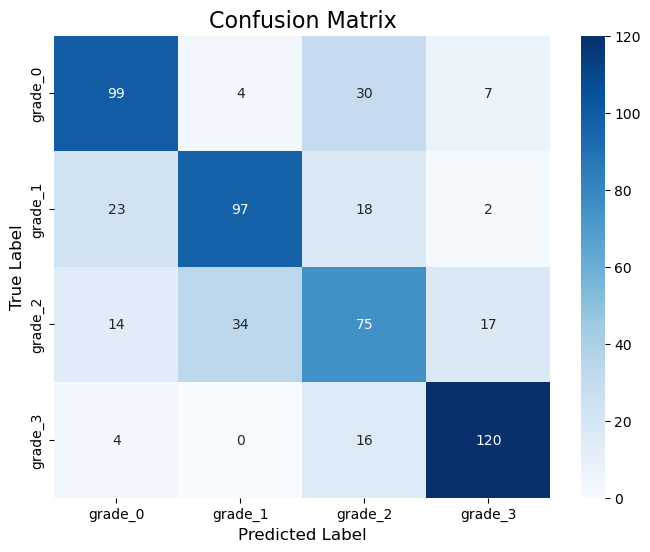

In [11]:
# ===================================================================
# KROK 6: EWALUACJA NA ZBIORZE TESTOWYM
# ===================================================================
print("\nOcenianie modelu na zbiorze testowym...")
results = trainer.predict(test_dataset)

# Wyciągnij predykcje i prawdziwe etykiety
y_pred = np.argmax(results.predictions, axis=1)
y_true = results.label_ids

print("\nRaport Klasyfikacji:")
print(classification_report(y_true, y_pred, target_names=config["class_names"]))

print("\nMacierz Pomyłek:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=config["class_names"], 
            yticklabels=config["class_names"])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()